# Consum elèctric d'un habitatge

### Per: *Pol Reviejo*, Data Scientist i Estadístic

El següent projecte consisteix en un anàlisi del consum elèctric d'un habitatge, del qual es disposa d'una sèrie temporal del seu consum elèctric per cada hora desde el 6 de Gener del 2025 fins al 4 de Febrer del 2025.

Es busca identificar patrons de quines franges temporals hi ha major o menor consum per posteriorment desenvolupar un model que faci prediccions sobre el futur consum de l'habitatge coneixent el consum històric observat.

________________________________________

Llibreries utilitzades pel projecte:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandasql as psql

_________________________________

## 01. Dades ```consumelectric_2025.xlsx```

Es carreguen les dades temporals del consum elèctric. Consisteix en el consum elèctric ```AE_kWh``` per cada dia (```Data```) i hora ```Hora``` del Març de 2023 al Gener de 2025. D'aquestes dades es pot generar informació extra com el dia de la setmana, mes o any.

In [2]:
df = pd.read_csv('Consum_historic.csv', delimiter=",", dtype=str)
df = df[ ["Data","Hora","AE_kWh"] ]

# Convertir 'Data' a datetime, especificant el format correcte
df['Data'] = pd.to_datetime(df['Data'], format='%d/%m/%Y')
# Convertir 'AE_kWh' a float, substituint les comes per punts
df['AE_kWh'] = df['AE_kWh'].str.replace(',', '.').astype(float)
df["Hora"] = df["Hora"].astype(float)

# Afegir el dia de la setmana
df['Dia'] = df['Data'].dt.day_name()
# Afegir el mes
df['Mes'] = df['Data'].dt.month_name()
# Afegir l'any
df['Any'] = df['Data'].dt.year
# Afegir el mes en numeric
df["Mes_num"] = None
num=1
for mes in ["January","February","March","April","May","June","July","August","September","October","November","December"]:
    df.loc[ df["Mes"]==mes, ["Mes_num"]] = num
    num=num+1

# Crear la columna 'Datetime' sumant les hores a la data
df["Datetime"] = df["Data"] + pd.to_timedelta(df["Hora"].astype(int) - 1, unit="h")

# Ordeno les dades per la Datetime, ja que en el excel orginal no venen ordenades
df = df.sort_values(by='Datetime')
df.index = range(len(df))

df

,Data,Hora,AE_kWh,Dia,Mes,Any,Mes_num,Datetime
0,2023-03-01,1.0,0.105,Wednesday,March,2023,3,2023-03-01 00:00:00
1,2023-03-01,2.0,0.098,Wednesday,March,2023,3,2023-03-01 01:00:00
2,2023-03-01,3.0,0.103,Wednesday,March,2023,3,2023-03-01 02:00:00
3,2023-03-01,4.0,0.096,Wednesday,March,2023,3,2023-03-01 03:00:00
4,2023-03-01,5.0,0.102,Wednesday,March,2023,3,2023-03-01 04:00:00
...,...,...,...,...,...,...,...,...
16219,2025-01-05,20.0,0.223,Sunday,January,2025,1,2025-01-05 19:00:00
16220,2025-01-05,21.0,0.197,Sunday,January,2025,1,2025-01-05 20:00:00
16221,2025-01-05,22.0,0.269,Sunday,January,2025,1,2025-01-05 21:00:00
16222,2025-01-05,23.0,0.243,Sunday,January,2025,1,2025-01-05 22:00:00


In [3]:
df.dtypes

Data        datetime64[ns]
Hora               float64
AE_kWh             float64
Dia                 object
Mes                 object
Any                  int32
Mes_num             object
Datetime    datetime64[ns]
dtype: object

## 02. **Evolució del consum elèctric total en kilowatts**

Represento la sèrie temporal del consum elèctric total en kilowatts per cada dia i corresponent hora. 

La sèrie al ser nivell hora té un comportament bastant sorollós però es poden identificar pics de consum o outliers amb valors alts, la majoria de vegades però el consum hora es concentra entre 0.1 i 0.4 .

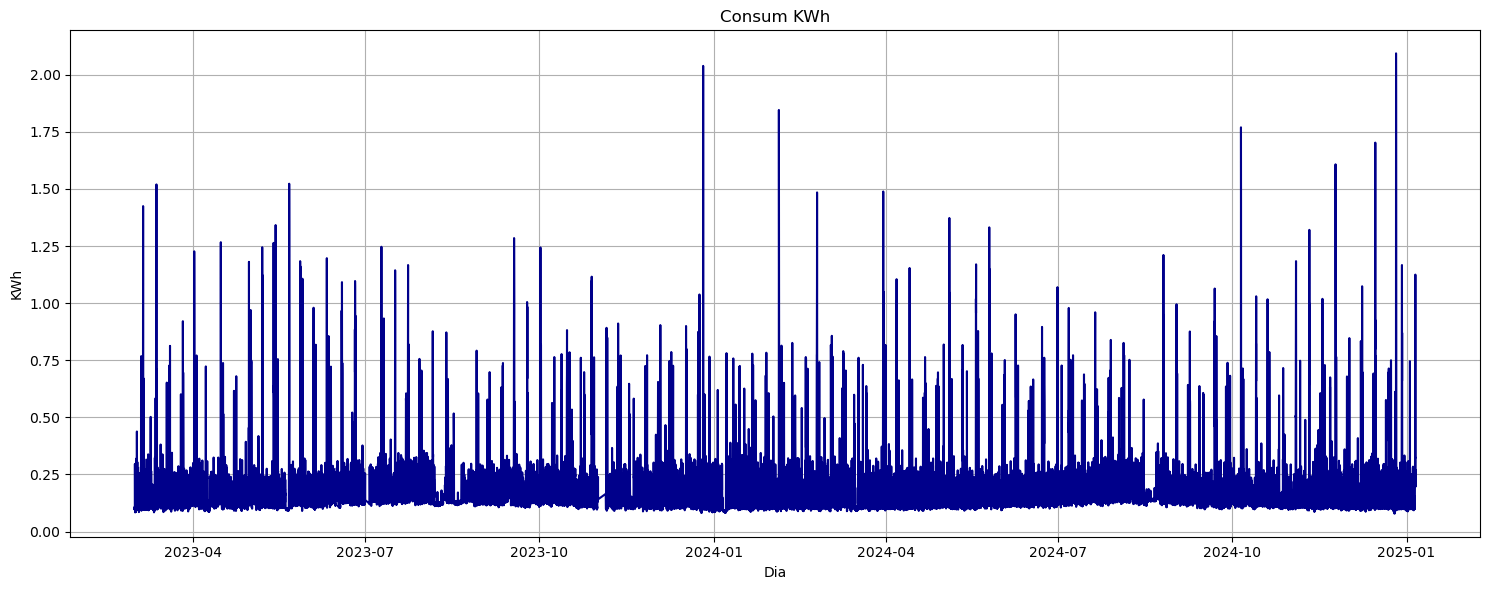

In [4]:
plt.figure(figsize=(15, 6))
plt.plot(df['Datetime'], df['AE_kWh'],color='darkblue')

plt.xlabel('Dia')
plt.ylabel('KWh')
plt.title('Consum KWh')
plt.grid(True)
plt.tight_layout()
plt.show()

Distribució dels mesos per 2023. Es comença a tenir info desde 2023.

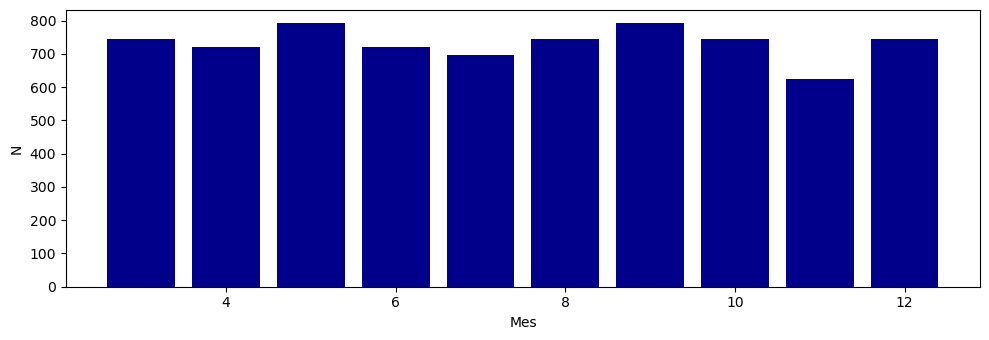

In [5]:
comp_mes_2023 = df.loc[ df["Any"]==2023 , ["Any","Mes_num"] ]["Mes_num"].value_counts()

plt.figure(figsize=(10,3.5))
plt.bar(x = comp_mes_2023.index, height = comp_mes_2023.values,color='darkblue')
plt.xlabel("Mes")
plt.ylabel("N")
plt.tight_layout()
plt.show()

Distribució dels mesos per 2024. Tots els mesos tenim info.

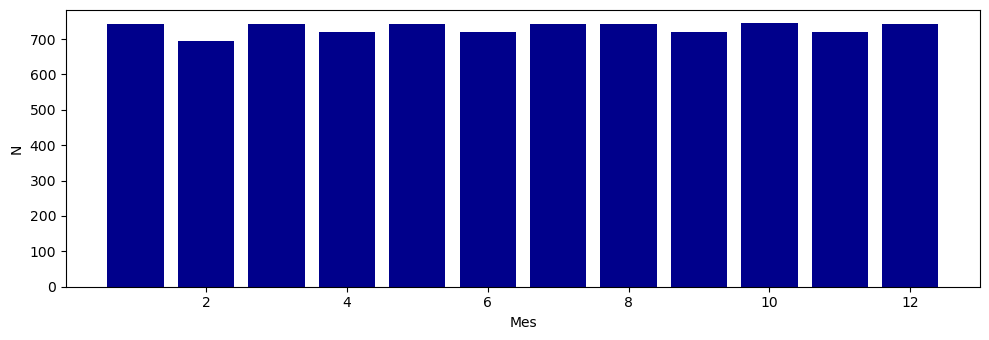

In [6]:
comp_mes_2024 = df.loc[ df["Any"]==2024 , ["Any","Mes_num"] ]["Mes_num"].value_counts()

plt.figure(figsize=(10,3.5))
plt.bar(x = comp_mes_2024.index, height = comp_mes_2024.values,color='darkblue')
plt.xlabel("Mes")
plt.ylabel("N")
plt.tight_layout()
plt.show()

Per 2025 tinc info només del Gener.

In [7]:
df.loc[ df["Any"]==2025 , ["Any","Mes_num"] ]["Mes_num"].value_counts()

Mes_num
1    120
Name: count, dtype: int64

_________________________

## 03. Estudi del consum elèctric

El consum elèctric es concentra entre ```0.1``` i ```0.25``` kilowatts per hora. La majoria de vegades és baix i distribuit de forme uniforme, però a vegades hi ha consums elèctrics excessius.

In [8]:
df["AE_kWh"].describe()

count    16224.000000
mean         0.190305
std          0.136710
min          0.078000
25%          0.115000
50%          0.154000
75%          0.221000
max          2.094000
Name: AE_kWh, dtype: float64

A través del boxplot es poden identificar casos rars d'excés de consum com aquells que estan a la cua del boxplot, és a dir els pics de consum que es veuen al gràfic anterior de la sèrie temporal. 

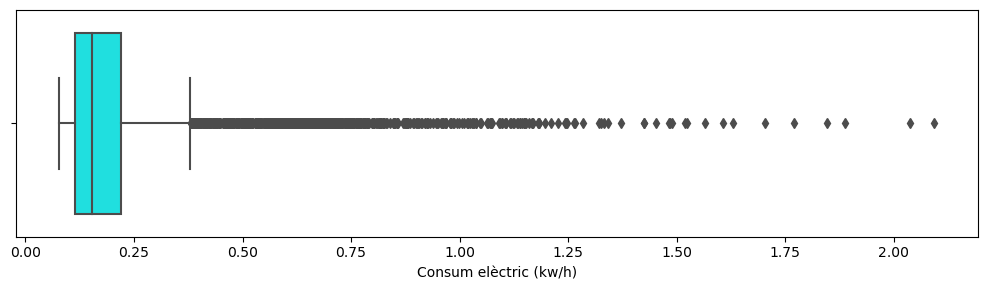

In [9]:
plt.figure(figsize=(10,3))

sns.boxplot(x=df["AE_kWh"],color='cyan')
plt.xlabel("Consum elèctric (kw/h)")
plt.tight_layout()
plt.show()

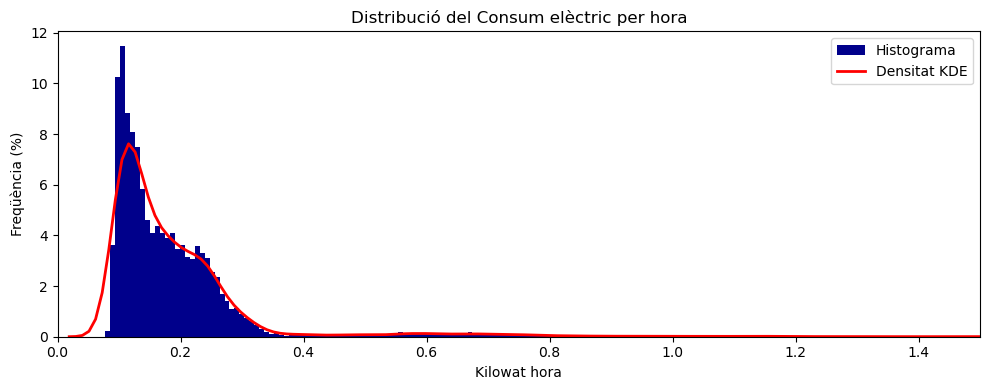

In [10]:
plt.figure(figsize=(10,4))

# Histograma
plt.hist(df["AE_kWh"], bins=250, color="darkblue", density=True, label="Histograma")
# KDE (estimació de densitat)
sns.kdeplot(df["AE_kWh"], color="red", linewidth=2, label="Densitat KDE")

plt.xlabel("Kilowat hora")
plt.ylabel("Freqüència (%)")
plt.title("Distribució del Consum elèctric per hora")
plt.legend()

plt.xlim(0,1.5)

plt.tight_layout()
plt.show()

### Consum diari

Es pot obtenir el consum elèctric diari com la suma del consum de cada una de les 24 hores del dia. 

$$consum_{d}=\sum_{h=1}^{24}consum_{d,h}$$

Es mostra la sèrie temporal del consum diari amb una mitjana mòbil setmanal en vermell i mensual en blau cel. S'identifiquen uns pics de consum cícilics que son els diumenges, on hi ha major consum elèctric. Però si s'observa la mitjana mòbil mensual no s'identifica una tendència o que el consum augmenti a mesura que avançen els mesos o anys.

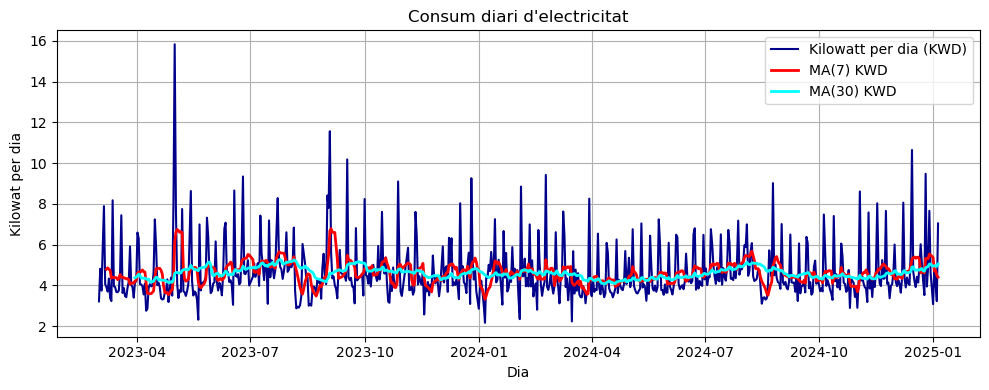

In [11]:
kwd = psql.sqldf(
'''
select Data, Dia, Mes, Mes_num, Any, sum(AE_kWh) as kwd 
from df
group by Data, Dia
'''
)

kwd["Data"] = pd.to_datetime(kwd["Data"]).dt.strftime('%Y-%m-%d')
kwd['Data'] = pd.to_datetime(kwd['Data'])

# Calculo una mitjana mobil
kwd["MA7"] = kwd["kwd"].rolling(window=7).mean()
kwd["MA14"] = kwd["kwd"].rolling(window=30).mean()

plt.figure(figsize=(10,4))
# Serie temporal
plt.plot(
    kwd["Data"],
    kwd["kwd"],
    color='darkblue',
    label="Kilowatt per dia (KWD)"
)
# Mitjanes mobils
plt.plot(kwd["Data"],kwd["MA7"],color='red',label="MA(7) KWD",linewidth=2)
plt.plot(kwd["Data"],kwd["MA14"],color='cyan',label="MA(30) KWD",linewidth=2)

plt.title("Consum diari d'electricitat")
plt.xlabel("Dia")
plt.ylabel("Kilowat per dia")

plt.legend()

plt.grid(True)
plt.tight_layout()

plt.show()

In [12]:
kwd[ ["Data","Dia","Mes","Any","kwd"] ].to_excel("Consum_diari.xlsx")

### Consum mensual

Es pot obtenir el consum elèctric mensual com la suma del consum de cada un dels dies d'un mes.

$$consum_{mes}=\sum_{dia \in mes}consum_{dia}$$

Com es veia a l'anterior gràfic tampoc s'aprecia que hi hagi mesos amb major o menor consum.

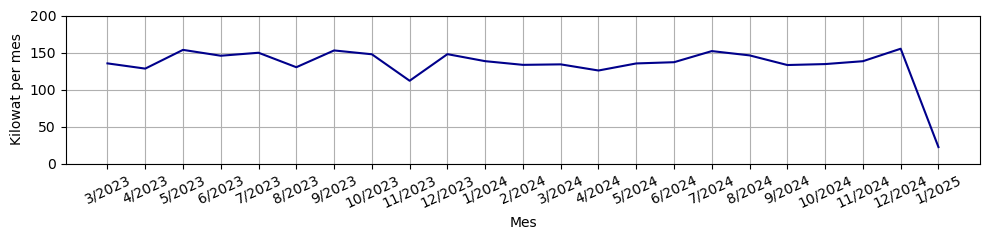

In [13]:
kwm = psql.sqldf(
'''
select Mes_num, Any, sum(AE_kWh) as kwm 
from df
group by Mes_num, Any
order by Any, Mes_num 
'''
)
kwm["Mes_any"] = kwm["Mes_num"].astype("string")+"/"+kwm["Any"].astype("string")

plt.figure(figsize=(10,2.5))
plt.plot(kwm["Mes_any"],kwm["kwm"],color='darkblue')
plt.xlabel("Mes")
plt.ylabel("Kilowat per mes")
plt.ylim(0,200)
plt.xticks(rotation=25)
plt.grid(True)
plt.tight_layout()
plt.show()

### Consum per dia de la setmana

En la línea del comentat anteriorment, si represento el consum per hora dels diferents dies de la setmana es veu com el diumenge és el dia amb major consum i més variabilitat en el consum.

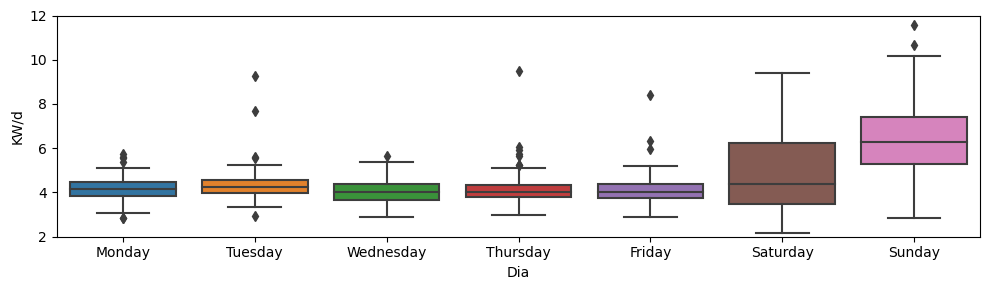

In [14]:
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
kwd["Dia"] = pd.Categorical(kwd["Dia"], categories=day_order, ordered=True)
# Plot
plt.figure(figsize=(10,3))
sns.boxplot(x=kwd["Dia"], y=kwd["kwd"], order=day_order)
plt.ylabel("KW/d")
plt.ylim(2,12)
plt.tight_layout()
plt.show()

### Consum per hora del dia

Per tal d'estudiar les hores del dia amb major consum s'ha calculat la mediana (en vermell) i els quartils 25$\%$ i 75$\%$ del consum representats en blau. Tal i com es veu, la matinada son els moments amb menor consum i a partir de les 6 comença a créixer fins a experimentar un pic a les 10, per tornar a baixar gradualment i tornar a pujar havent-hi un altre pic a les 15.

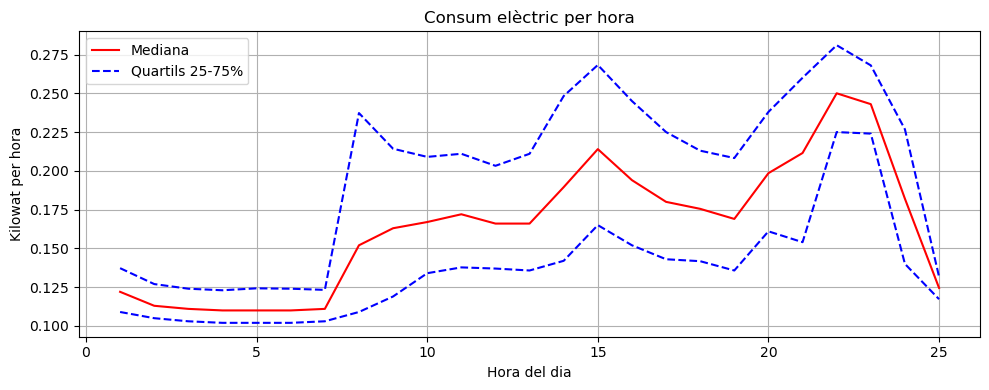

In [15]:
desc_hora = df.groupby('Hora')['AE_kWh'].agg(
    med='median',
    quart1=lambda x: x.quantile(0.25),
    quart3=lambda x: x.quantile(0.75)
).reset_index()


plt.figure(figsize=(10,4))

plt.plot( desc_hora["Hora"], desc_hora["med"], color='red', label="Mediana")
plt.plot( desc_hora["Hora"], desc_hora["quart1"], color='blue', label="Quartils 25-75%",linestyle="--")
plt.plot( desc_hora["Hora"], desc_hora["quart3"], color='blue',linestyle="--")

plt.grid(True)

plt.legend()

plt.xlabel("Hora del dia")
plt.ylabel("Kilowat per hora")

plt.title("Consum elèctric per hora")

plt.tight_layout()
plt.show()

Repeteixo el gràfic anterior però dividint-ho per cada dia de la setmana. Tots els dies tenen un patró semblant excepte el Diumenge, degut a l'ús de les rentadores.

In [16]:
desc_hora_dia = df.groupby(['Hora', 'Dia'])['AE_kWh'].agg(
    med='median',
    quart1=lambda x: x.quantile(0.25),
    quart3=lambda x: x.quantile(0.75)
).reset_index()

def consum_hora(dies,titol):
    plt.figure(figsize=(10,4))
    
    for dia in dies:
        df_filtr = desc_hora_dia[ desc_hora_dia["Dia"]==dia ]
        plt.plot( df_filtr["Hora"], df_filtr["med"], label=dia,)

    plt.grid(True)

    plt.xlabel("Hora del dia")
    plt.ylabel("Kilowat per hora")

    plt.title(titol)

    plt.legend()
    plt.show()

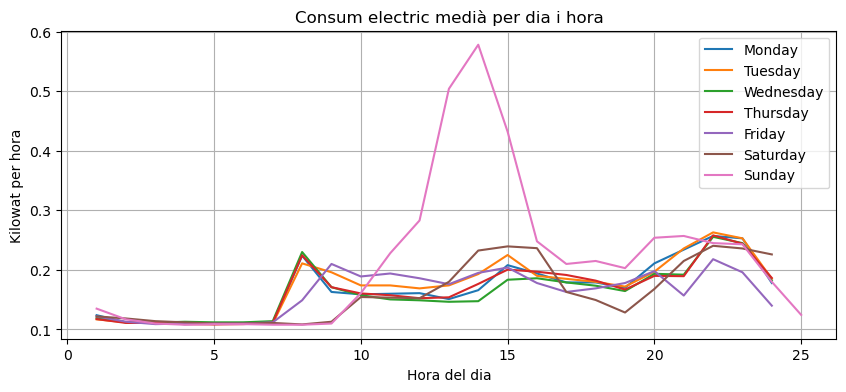

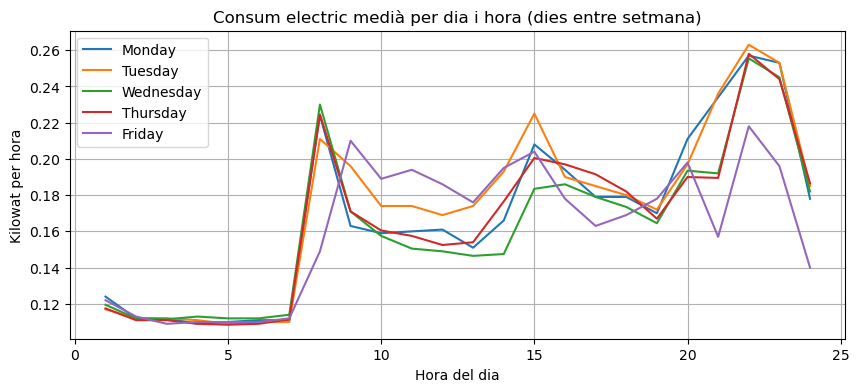

In [17]:
consum_hora( ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"], "Consum electric medià per dia i hora")
consum_hora( ["Monday","Tuesday","Wednesday","Thursday","Friday"] , "Consum electric medià per dia i hora (dies entre setmana)")